In [ ]:
import requests
"""
    爬取指定网页的疫情数据
    2019-12-31 至 2020-11-02（数据库暂时更新到11月2日，目前该网站最新可将数据更新至昨天）
    全球共200多个国家和地区
    数据来源：https://covid.ourworldindata.org/data/owid-covid-data.json
"""
url = "https://covid.ourworldindata.org/data/owid-covid-data.json"
response = requests.get(url)

In [ ]:
import json
a = json.loads(response.text)
"""
    将爬取的网页内容保存成json格式
"""

In [ ]:
import pymysql
"""
    使用MySQL数据库中创建本地数据库：covid19，并在数据库中创建数据表：worlddata
    该数据表包括日期、地名、今日新增病例、今日死亡病例、累计新增病例、累计死亡病例6列
"""
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='201410101bxp',
    db='covid19'
)
cursor = connection.cursor()
total_case = a["ABW"]["data"][0]["total_cases"] if "total_cases" in a["ABW"]["data"][0].keys() else 0.0
total_death = a["ABW"]["data"][0]["total_deaths"] if "total_deaths" in a["ABW"]["data"][0].keys() else 0.0
data_h = (a["ABW"]["data"][0]["date"], # 时间
          a["ABW"]["location"], # 地名
          a["ABW"]["data"][0]["new_cases"], # 新增病例
          a["ABW"]["data"][0]["new_deaths"], # 新增死亡
          total_case, # 累计病例
          total_death # 累计死亡
          )

In [ ]:
"""
    解析json数据并将数据提交至本地数据库的数据表中，共53843行
"""
# try:
for i in a.keys():
    for j in range(len(a[i]["data"])):
        total_case = float(a[i]["data"][j]["total_cases"]) if "total_cases" in a[i]["data"][j].keys() else 0.0
        total_death = float(a[i]["data"][j]["total_deaths"]) if "total_deaths" in a[i]["data"][j].keys() else 0.0
        new_case = float(a[i]["data"][j]["new_cases"]) if "new_cases" in a[i]["data"][j].keys() else 0.0
        new_death = float(a[i]["data"][j]["new_deaths"]) if "new_deaths" in a[i]["data"][j].keys() else 0.0
        date = a[i]["data"][j]["date"] if "date" in a[i]["data"][j] else "0000-00-00"
        name = a[i]["location"]
        data_h = (date, # 时间
                  name.replace("'",""), # 地名
                  new_case, # 新增病例
                  new_death, # 新增死亡
                  total_case, # 累计病例
                  total_death # 累计死亡
                  )
        cursor.execute(
            "insert into worlddata(date,name,newcase,newdeath,totalcase,totaldeath) values('%s','%s','%s','%s','%s','%s')" % (
                data_h))
        connection.commit()
# except:
#     print("error")
#     connection.rollback()


In [12]:
import pymysql
import matplotlib.pyplot as plt

def cases(t,n):
    """
        获取指定日期、国家的疫情数据
    """
    str_t = "'" + str(t) + "'"
    str_n = "'" + str(n) + "'"
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='covid19'
        )
    cursor = connection.cursor()
    sql = "select newcase,newdeath,totalcase,totaldeath from worlddata where date={} and name={}".format(str_t,str_n)
    try:
        cursor.execute(sql)
        list1 = cursor.fetchall()
        str_r = "今日新增："+str(list1[0][0])+" "+"今日死亡："+str(list1[0][1])+ " " +"累计新增："+" "+str(list1[0][2])+" "+"累计死亡："+str(list1[0][3])
    except:
        str_r = "error"
    return str_r
"""
    例如：获取2020年4月10日的中国疫情数据
"""
cases("2020-04-10","China")

'今日新增：55.0 今日死亡：1.0 累计新增： 82925.0 累计死亡：3340.0'

In [11]:
"""
    获取世界指定日期的疫情数据，例如：2020年10月15日
"""
cases("2020-10-15","World")


'今日新增：388382.0 今日死亡：6038.0 累计新增： 38639228.0 累计死亡：1093329.0'

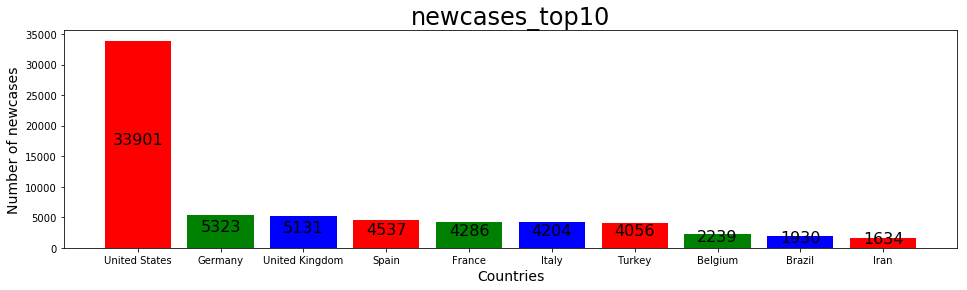

In [20]:
"""
    选取指定日期新增病例最多的十个国家并作柱状图
    
"""
def newcases_top10(t):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='covid19'
        )
    cursor = connection.cursor()
    str_t = "'" + str(t) + "'"
    sql = "select name,newcase from worlddata where date={} order by newcase desc".format(str_t)
    # try:
    # list1 = []
    try:
        cursor.execute(sql)
        newcase_1 = cursor.fetchall() #接收全部的返回结果；
    except:
        return "error"
    name_list = []
    newcase_list = []
    for i in range(1,11):
        name_list.append(newcase_1[i][0])
        newcase_list.append(newcase_1[i][1])
    fig = plt.figure(figsize=(16,4))
    plt.bar(range(len(newcase_list)), newcase_list,color='rgb',tick_label=name_list)
    for x,y in enumerate(newcase_list):
        plt.text(x,y/2,int(y),ha='center',fontsize=16)
    plt.title('newcases_top10',fontsize=24)
    plt.xlabel('Countries',fontsize=14)
    plt.ylabel('Number of newcases',fontsize=14)
    plt.show()
"""
    例如：获取2020年4月10日新增病例最多的十个国家
"""
newcases_top10("2020-04-10")

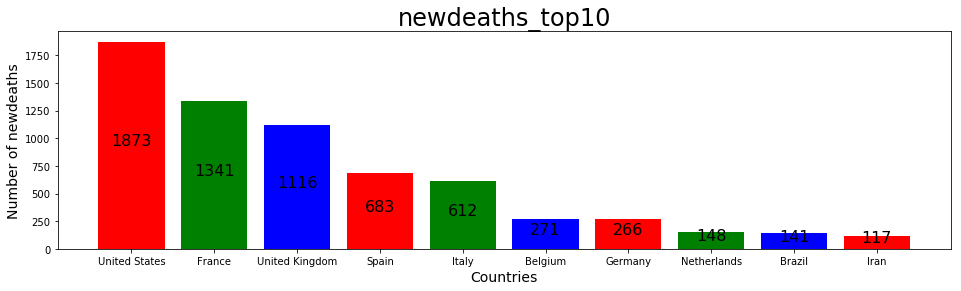

In [19]:
"""
    选取指定日期新增死亡最多的十个国家并作柱状图
    
"""
def newdeaths_top10(t):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='covid19'
        )
    cursor = connection.cursor()
    str_t = "'" + str(t) + "'"
    sql = "select name,newdeath from worlddata where date={} order by newdeath desc".format(str_t)
    # try:
    # list1 = []
    try:
        cursor.execute(sql)
        newdeath_1 = cursor.fetchall() #接收全部的返回结果；
    except:
        return "error"
    name_list = []
    newdeath_list = []
    for i in range(1,11):
        name_list.append(newdeath_1[i][0])
        newdeath_list.append(newdeath_1[i][1])
    fig = plt.figure(figsize=(16,4))
    plt.bar(range(len(newdeath_list)), newdeath_list,color='rgb',tick_label=name_list)
    for x,y in enumerate(newdeath_list):
        plt.text(x,y/2,int(y),ha='center',fontsize=16)
    plt.title('newdeaths_top10',fontsize=24)
    plt.xlabel('Countries',fontsize=14)
    plt.ylabel('Number of newdeaths',fontsize=14)
    plt.show()
"""
    例如：获取2020年4月10日新增死亡最多的十个国家
"""
newdeaths_top10("2020-04-10")

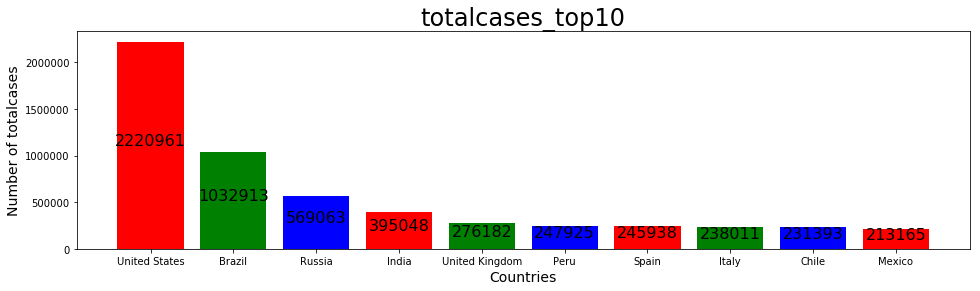

In [22]:
"""
    选取指定日期累计病例最多的十个国家并作柱状图
    
"""
def totalcases_top10(t):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='covid19'
        )
    cursor = connection.cursor()
    str_t = "'" + str(t) + "'"
    sql = "select name,totalcase from worlddata where date={} order by totalcase desc".format(str_t)
    # try:
    # list1 = []
    try:
        cursor.execute(sql)
        totalcases_1 = cursor.fetchall() #接收全部的返回结果；
    except:
        return "error"
    name_list = []
    totalcases_list = []
    for i in range(1,11):
        name_list.append(totalcases_1[i][0])
        totalcases_list.append(totalcases_1[i][1])
    fig = plt.figure(figsize=(16,4))
    plt.bar(range(len(totalcases_list)), totalcases_list,color='rgb',tick_label=name_list)
    for x,y in enumerate(totalcases_list):
        plt.text(x,y/2,int(y),ha='center',fontsize=16)
    plt.title('totalcases_top10',fontsize=24)
    plt.xlabel('Countries',fontsize=14)
    plt.ylabel('Number of totalcases',fontsize=14)
    plt.show()
"""
    例如：获取2020年6月20日累计病例最多的十个国家
"""
totalcases_top10("2020-06-20")

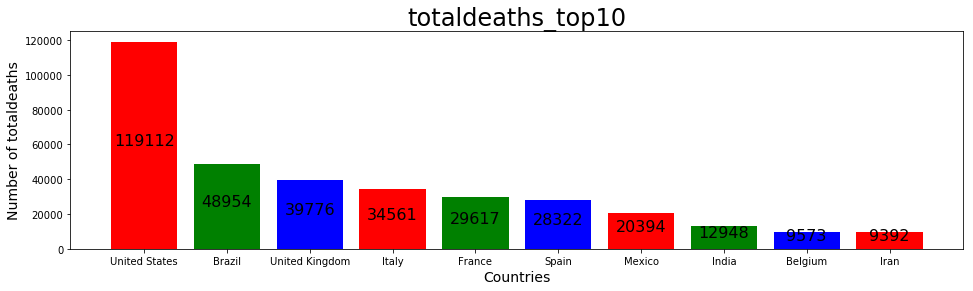

In [24]:
"""
    选取指定日期累计死亡最多的十个国家并作柱状图
    
"""
def totaldeaths_top10(t):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='covid19'
        )
    cursor = connection.cursor()
    str_t = "'" + str(t) + "'"
    sql = "select name,totaldeath from worlddata where date={} order by totaldeath desc".format(str_t)
    # try:
    # list1 = []
    try:
        cursor.execute(sql)
        totaldeaths = cursor.fetchall() #接收全部的返回结果；
    except:
        return "error"
    name_list = []
    totaldeaths_list = []
    for i in range(1,11):
        name_list.append(totaldeaths[i][0])
        totaldeaths_list.append(totaldeaths[i][1])
    fig = plt.figure(figsize=(16,4))
    plt.bar(range(len(totaldeaths_list)), totaldeaths_list,color='rgb',tick_label=name_list)
    for x,y in enumerate(totaldeaths_list):
        plt.text(x,y/2,int(y),ha='center',fontsize=16)
    plt.title('totaldeaths_top10',fontsize=24)
    plt.xlabel('Countries',fontsize=14)
    plt.ylabel('Number of totaldeaths',fontsize=14)
    plt.show()
"""
    例如：获取2020年8月1日累计死亡最多的十个国家
"""
totaldeaths_top10("2020-06-20")

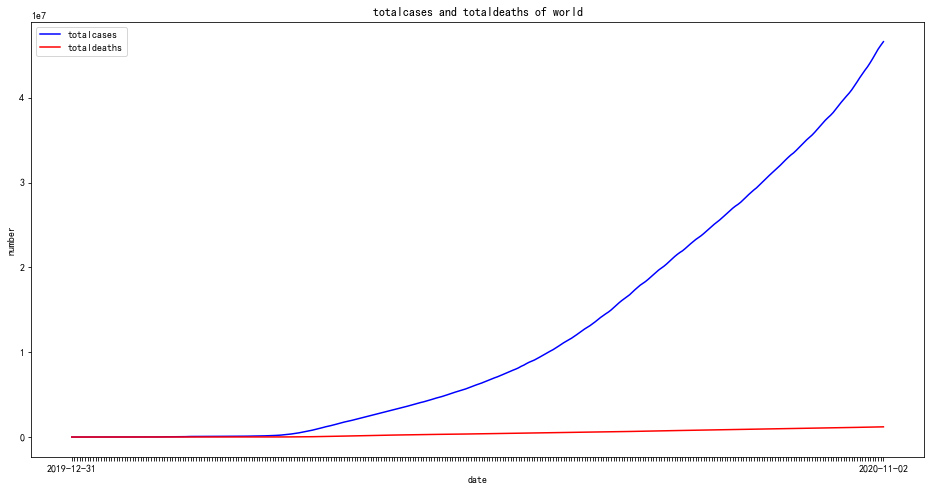

In [35]:
"""
    获取指定国家或地区的疫情累计病例、累计死亡走势
"""
def total_trend(t):
    str_t = "'" + str(t) + "'"
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='covid19'
        )
    cursor = connection.cursor()
    sql = "select date,totalcase,totaldeath from worlddata where name={} order by date asc".format(str_t)
    # try:
    # list1 = []
    try:
        cursor.execute(sql)
        newcase_2 = cursor.fetchall() #接收全部的返回结果；
    except:
        return "error"
    
    x_list = []
    x_list2 = []
    y_list = []
    y_list2 = []
    x_list.append(str(newcase_2[0][0]))
    for i in range(len(newcase_2)):
        # x_list.append(str(newcase_2[0]))
        y_list.append(int(newcase_2[i][1]))
        y_list2.append(int(newcase_2[i][2]))
    for i in range(len(newcase_2)-2):
        x_list.append("")
    x_list.append(str(newcase_2[-1][0]))
    x = range(len(x_list))
    fig = plt.figure(figsize=(16,8))
    plt.plot(x,y_list,color='blue', label='totalcases')
    plt.plot(x,y_list2,color='red', label='totaldeaths')
    plt.xticks(x,x_list)
    plt.legend() # 显示图例
    plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
    plt.title("totalcases and totaldeaths of {}".format(t)) #图名
    plt.xlabel("date")#x轴标签
    plt.ylabel("number")#y轴标签
    plt.show()
"""
    例如：获取全球累计病例,累计死亡走势图
"""
total_trend("world")

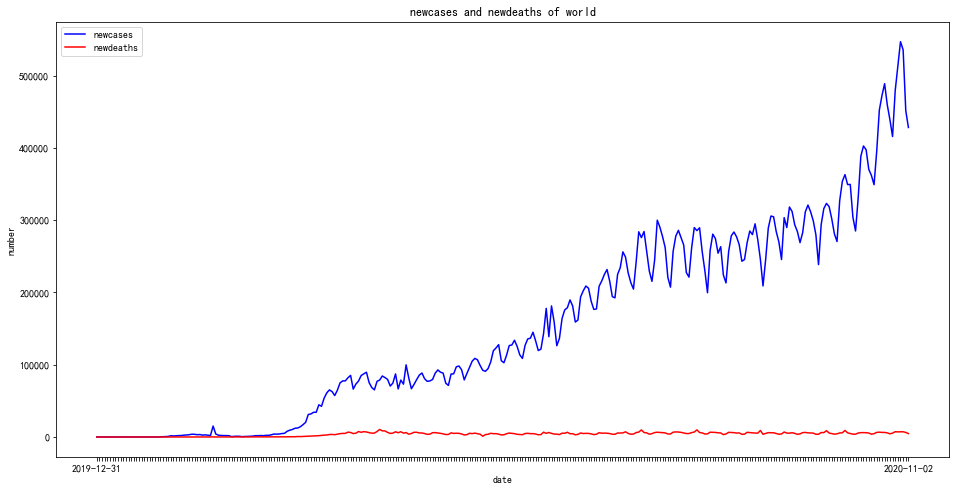

In [36]:
"""
    获取指定国家或地区的疫情新增病例、新增死亡走势
"""
def new_trend(t):
    str_t = "'" + str(t) + "'"
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='covid19'
        )
    cursor = connection.cursor()
    sql = "select date,newcase,newdeath from worlddata where name={} order by date asc".format(str_t)
    # try:
    # list1 = []
    try:
        cursor.execute(sql)
        newcase_2 = cursor.fetchall() #接收全部的返回结果；
    except:
        return "error"
    
    x_list = []
    x_list2 = []
    y_list = []
    y_list2 = []
    x_list.append(str(newcase_2[0][0]))
    for i in range(len(newcase_2)):
        # x_list.append(str(newcase_2[0]))
        y_list.append(int(newcase_2[i][1]))
        y_list2.append(int(newcase_2[i][2]))
    for i in range(len(newcase_2)-2):
        x_list.append("")
    x_list.append(str(newcase_2[-1][0]))
    x = range(len(x_list))
    fig = plt.figure(figsize=(16,8))
    plt.plot(x,y_list,color='blue', label='newcases')
    plt.plot(x,y_list2,color='red', label='newdeaths')
    plt.xticks(x,x_list)
    plt.legend() # 显示图例
    plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
    plt.title("newcases and newdeaths of {}".format(t)) #图名
    plt.xlabel("date")#x轴标签
    plt.ylabel("number")#y轴标签
    plt.show()
"""
    例如：获取全球新增病例,新增死亡走势图
"""
new_trend("world")